In [1]:
import requests
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from genaibook.core import SampleURL, get_device
import torch

In [2]:
device = get_device()

In [3]:
clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)

In [4]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

In [5]:
url = SampleURL.LionExample
image = Image.open(requests.get(url, stream=True).raw)

In [6]:
image_inputs = processor(images=image, return_tensors='pt')
pixel_values = image_inputs['pixel_values']
pixel_values.shape, pixel_values.min(), pixel_values.max()

(torch.Size([1, 3, 224, 224]), tensor(-1.7923), tensor(2.0179))

In [7]:
processor.image_processor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

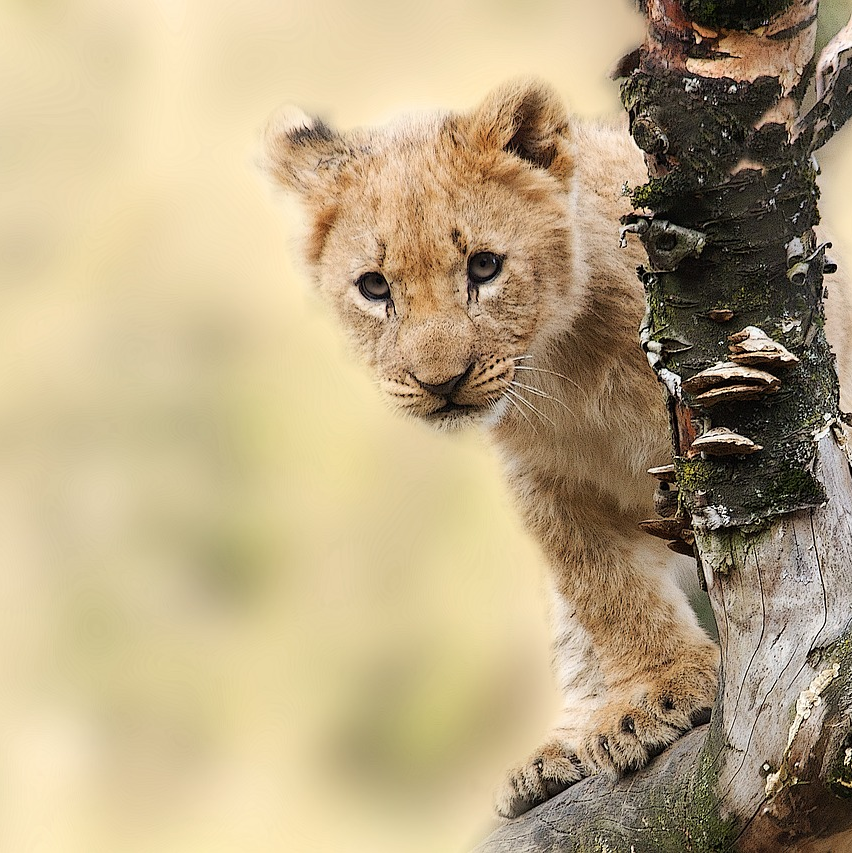

In [8]:
width, height = image.size
crop_length = min(image.size)
left = (width - crop_length) /2
right = (width + crop_length) / 2
top = (height - crop_length) / 2
bottom = (height + crop_length) / 2
cropped = image.crop((left, top, right, bottom))
cropped

In [9]:
with torch.inference_mode():
    output = clip.vision_model(pixel_values.to(device))
image_embeddings = output.pooler_output
image_embeddings.shape

torch.Size([1, 1024])

In [10]:
prompts = [
    "a photo of a lion",
    "a photo of a zebra"
]

In [11]:
text_inputs = processor(text=prompts, return_tensors='pt', padding=True) # padding means all inputs have same length
text_inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  5567, 49407],
        [49406,   320,  1125,   539,   320, 22548, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}

In [12]:
text_inputs = {k: v.to(device) for k, v in text_inputs.items()}

In [13]:
with torch.inference_mode():
    text_output = clip.text_model(**text_inputs)

text_embeddings = text_output.pooler_output
text_embeddings.shape

torch.Size([2, 768])

In [14]:
# Use image vectors and text vectors projections so they are same dimensions:
print(clip.text_projection)
print(clip.visual_projection)

Linear(in_features=768, out_features=768, bias=False)
Linear(in_features=1024, out_features=768, bias=False)


In [15]:
with torch.inference_mode():
    text_embeddings = clip.text_projection(text_embeddings)
    image_embeddings = clip.visual_projection(image_embeddings)
text_embeddings.shape, image_embeddings.shape

(torch.Size([2, 768]), torch.Size([1, 768]))

In [16]:
# Normalize vectors with unit norms
text_embeddings = text_embeddings / text_embeddings.norm(p=2, dim=1, keepdim=True)
image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=1, keepdim=True)

In [17]:
similarities = torch.matmul(text_embeddings, image_embeddings.T)
similarities

tensor([[0.2171],
        [0.1888]], device='mps:0')

In [ ]:
# Scale to get probabilities for each prompt matching the image
similarities = 100 * torch.matmul(text_embeddings, image_embeddings.T)
similarities.softmax(dim=0).cpu()

tensor([[0.9441],
        [0.0559]])

Let's add more prompts:

In [19]:
prompts = [
    'a photo of a lion',
    'a photo of a zebra',
    'a photo of a cat',
    'a photo of an adorable lion cub',
    'a puppy',
    'a lion behind a branch'
]

In [20]:
inputs = processor(text=prompts, images=image, return_tensors='pt', padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}
outputs = clip(**inputs)
logits_per_image = outputs.logits_per_image
probabilities = logits_per_image.softmax(dim=1)

In [21]:
probabilities = probabilities[0].cpu().detach().tolist()

In [23]:
for prob, prompt in sorted(zip(probabilities, prompts), reverse=True):
    print(f'{100*prob: 2.0f}%: {prompt}')

 89%: a photo of an adorable lion cub
 9%: a lion behind a branch
 2%: a photo of a lion
 0%: a photo of a zebra
 0%: a photo of a cat
 0%: a puppy
